## Compare M2 tidal velocities with theory

Compare vertical structure of M2 tidal velocities calculated from harmonic analysis (UTide) with the tidal bottom boundary layer model of Soulsby (1983).

In [1]:
%matplotlib notebook

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import gsw
from scipy.special import ker,kei
import lmfit

### Load UTide analysis

In [2]:
dstide = xr.open_dataset('data/utide_results.nc')

In [3]:
i = 1j
ap = 0.5*(dstide['Lsmaj']+dstide['Lsmin'])*np.exp(i*(dstide['theta']-dstide['g'])*np.pi/180)
am = 0.5*(dstide['Lsmaj']-dstide['Lsmin'])*np.exp(i*(dstide['theta']+dstide['g'])*np.pi/180)
Ap = np.abs(ap)
Am = np.abs(am)
epsilonp = np.angle(ap)*180/np.pi
epsilonm = np.angle(am)*180/np.pi

In [4]:
dims = ('height', 'constituent')
dstide['ap'] = (dims, ap)
dstide['am'] = (dims, am)
dstide['Ap'] = (dims, Ap)
dstide['Am'] = (dims, Am)
dstide['epsilonp'] = (dims, epsilonp)
dstide['epsilonm'] = (dims, epsilonm)

### Symbols and terminology

| Parameter                    | Soulsby (theory) | Codiga (UTide)           |
|------------------------------|------------------|--------------------------|
| major axis                   | $U_a$            | $L^{smaj}_q$             |
| minor axis                   | $U_b$            | $L^{smin}_q$             |
| complex anticlockwise vector | $R_+$            | $a^+_q$                  |
| complex clockwise vector     | $R_-$            | $a^-_q$                  |
| anticlockwise amplitude      | $|R_+|$          | $A^+_q$                  |
| clockwise amplitude          | $|R_-|$          | $A^-_q$                  |
| orientation angle            | $\Phi$           | $\theta_q$               |
| phase lag                    | $\phi$           | $g_q$                    |
| anticlockwise phase          | $\phi_+$         | $\epsilon^+_q$, -$g^+_q$ |
| clockwise phase              | $\phi_-$         | $\epsilon^-_q$, $g^-_q$  |

### Plot M2 parameters

In [5]:
zi = np.arange(0,len(dstide['height'])-7)
m2i, = np.where(dstide['constituent'] == 'M2')

<IPython.core.display.Javascript object>


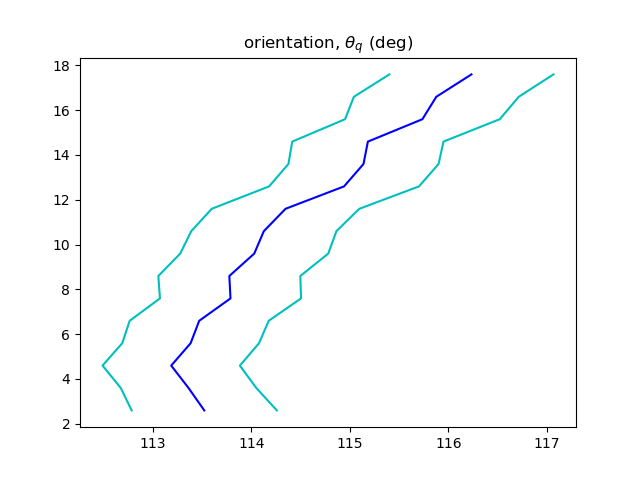

Text(0.5, 1.0, 'orientation, $\\theta_q$ (deg)')

In [6]:
plt.figure()
plt.plot(dstide['theta'][zi,m2i],dstide['height'][zi],'b')
plt.plot(dstide['theta'][zi,m2i]+dstide['theta_ci'][zi,m2i],
         dstide['height'][zi],'c')
plt.plot(dstide['theta'][zi,m2i]-dstide['theta_ci'][zi,m2i],
         dstide['height'][zi],'c')
plt.title('orientation, $\\theta_q$ (deg)')

<IPython.core.display.Javascript object>


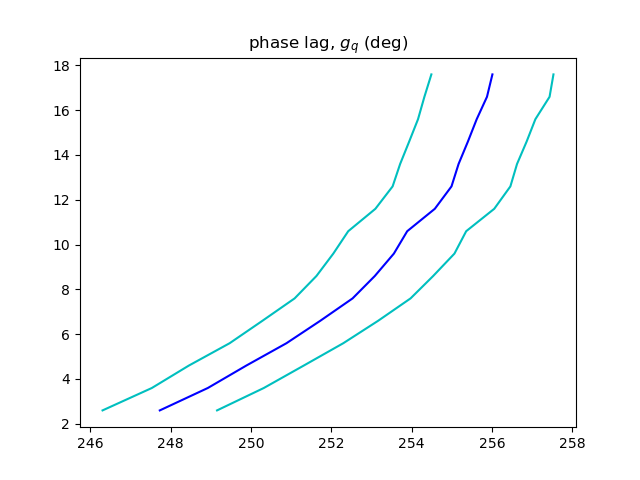

Text(0.5, 1.0, 'phase lag, $g_q$ (deg)')

In [7]:
plt.figure()
plt.plot(dstide['g'][zi,m2i],dstide['height'][zi],'b')
plt.plot(dstide['g'][zi,m2i]+dstide['g_ci'][zi,m2i],
         dstide['height'][zi],'c')
plt.plot(dstide['g'][zi,m2i]-dstide['g_ci'][zi,m2i],
         dstide['height'][zi],'c')
plt.title('phase lag, $g_q$ (deg)')

### Define model equations

In [7]:
def planetary_bbl_structure(ustar,zo,z,f):
    '''
    Calculate vertical structure of a planetary boundary layer (a.k.a.
    bottom Ekman layer) following Soulsby (1983). The calculation assumes
    that the eddy viscosity increases linearly with height.
    '''

    i = 1j 
    kappa = 0.41 # Von Karman's constant
    
    # non-dimensional height and roughness length
    xi = 2*np.sqrt(f*z/(kappa*ustar))
    xio = 2*np.sqrt(f*zo/(kappa*ustar))
    
    # Q/Qinf in Equation 31 of Soulsby (1983)
    fac = (1-(ker(xi)*ker(xio) + kei(xi)*kei(xio))/
             (ker(xio)**2 + kei(xio)**2) + 
           i*(ker(xi)*kei(xio) - kei(xi)*ker(xio))/
             (ker(xio)**2 + kei(xio)**2))

    return fac

def rotating_planetary_bbl_coeffs(ustar,zo,Rpinf,Rminf,z,sigma,f):
    if sigma+f < 0:
        Rpinf = np.abs(Rpinf)*np.exp(-i*np.angle(Rpinf))
    if sigma-f > 0:
        Rminf = np.abs(Rminf)*np.exp(-i*np.angle(Rminf))

    Rp = Rpinf*planetary_bbl_structure(ustar,zo,z,sigma+f)
    Rm = Rminf*planetary_bbl_structure(ustar,zo,z,sigma-f)

    phip = np.angle(Rp)
    phim = np.angle(Rm)

    if sigma+f < 0:
        # southern hemisphere (needs testing) 
        # tidal oscillation lower frequency than f
        phip = -np.angle(Rp)
        Rp = np.abs(Rp)*np.exp(1j*phip)

    if sigma-f > 0:
        # northern hemisphere 
        # tidal oscillation higher frequency than f
        phim = -np.angle(Rm)
        Rm = np.abs(Rm)*np.exp(1j*phim)
        
    return Rp,Rm

def bbl_coeffs_model_obs_diff(x,args):
    '''
    x = array of real parameters
    args = additional arguments
    '''
    
    ustar,zo,Rpinf_real,Rpinf_imag,Rminf_real,Rminf_imag = x
    z,sigma,f,ap_real,ap_imag,am_real,am_imag = args
    
    print(ustar)
    print(ap_real)

In [8]:
print('Rpinf:',np.array(ap[zi[-1],m2i]))
print('Rminf:',np.array(am[zi[-1],m2i]))

Rpinf: [-0.01266984-0.01071498j]
Rminf: [0.01701654+0.00369331j]


In [9]:
Rpinf = np.array(ap[zi[-1],m2i])
Rminf = np.array(am[zi[-1],m2i])
ustar = 0.001
zo = 0.01

z = np.arange(0.05,25,0.05)
sigma = 1.4e-4
f = gsw.f(35+8.4585/60)

In [10]:
Rpinf

array([-0.01266984-0.01071498j])

In [11]:
def fit_function(params, z=None, dat_ccw=None, dat_cw=None):
    
    Rp,Rm = rotating_planetary_bbl_coeffs(params['ustar'],
                                          params['zo'],
                                          params['Rpinf_real']+1j*params['Rpinf_imag'],
                                          params['Rminf_real']+1j*params['Rminf_imag'],
                                          z,
                                          params['sigma'],
                                          params['f'])

    resid1 = np.abs(np.real(dat_ccw) - np.real(Rp))
    resid2 = np.abs(np.imag(dat_ccw) - np.imag(Rp))
    resid3 = np.abs(np.real(dat_cw) - np.real(Rm))
    resid4 = np.abs(np.imag(dat_cw) - np.imag(Rm))    
    
    return np.concatenate((resid1, resid2, resid3, resid4))

params = lmfit.Parameters()
params.add('f', value=f, vary=False)
params.add('sigma', value=sigma, vary=False)
params.add('zo', value=0.03,vary=True)
params.add('ustar', value=ustar)
params.add('Rpinf_real', value=np.real(Rpinf),vary=True)
params.add('Rpinf_imag', value=np.imag(Rpinf),vary=True)
params.add('Rminf_real', value=np.real(Rminf),vary=True)
params.add('Rminf_imag', value=np.imag(Rminf),vary=True)

dat_z = np.array(dstide['height'][zi])
dat_ccw = np.array(ap[zi,m2i]).flatten()
dat_cw = np.array(am[zi,m2i]).flatten()

out_m2 = lmfit.minimize(fit_function, params, args=(dat_z, dat_ccw, dat_cw))

In [12]:
out_m2.covar

array([[ 2.02575098e-04, -9.91956734e-07,  1.20697575e-07,
        -7.67525158e-08, -3.57914566e-07,  4.96254820e-09],
       [-9.91956734e-07,  7.84700766e-09, -1.76052756e-09,
         1.63697904e-09,  4.00066149e-09,  3.16071242e-09],
       [ 1.20697575e-07, -1.76052756e-09,  2.26537354e-09,
        -5.39067901e-10, -1.09264986e-09, -1.24296627e-09],
       [-7.67525158e-08,  1.63697904e-09, -5.39067901e-10,
         2.29704426e-09,  1.08391373e-09,  1.34166964e-09],
       [-3.57914566e-07,  4.00066149e-09, -1.09264986e-09,
         1.08391373e-09,  4.24515655e-09,  2.38617616e-09],
       [ 4.96254820e-09,  3.16071242e-09, -1.24296627e-09,
         1.34166964e-09,  2.38617616e-09,  5.31563757e-09]])

In [13]:
z = np.arange(0.1,20,0.01)

zo_fit = float(out_m2.params['zo'])
ustar_fit = float(out_m2.params['ustar'])
Rpinf_fit = float(out_m2.params['Rpinf_real'])+1j*float(out_m2.params['Rpinf_imag'])
Rminf_fit = float(out_m2.params['Rminf_real'])+1j*float(out_m2.params['Rminf_imag'])

Rp,Rm = rotating_planetary_bbl_coeffs(ustar_fit,zo_fit,Rpinf_fit,Rminf_fit,z,sigma,f)

print('zo',zo_fit)
print('ustar',ustar_fit)

zo 0.0956430540641897
ustar 0.0013023059579274935


In [14]:
out_m2.params['zo']
out_m2.params['ustar']

<Parameter 'ustar', value=0.0013023059579274935 +/- 8.86e-05, bounds=[-inf:inf]>

### Station M 

The model will be fit to the complex rotary coefficients calculated from the UTide results. The free parameters should include:

* Anticlockwise coefficients above BBL: $\text{Re}(R_+^{\infty})$, $\text{Im}(R_+^{\infty})$
* Clockwise coefficients above BBL: $\text{Re}(R_-^{\infty})$, $\text{Im}(R_-^{\infty})$
* Maximum shear velocity ($u_{*m}$)
* Roughness length ($z_o$)

This is a total of six parameters. The coefficients above the BBL could also potentially be treated as known paramaters, using the top bin from the data.

The M2 constituent is the strongest signal. Can other constituents be used? Will the value of $z_o$ change?

<IPython.core.display.Javascript object>


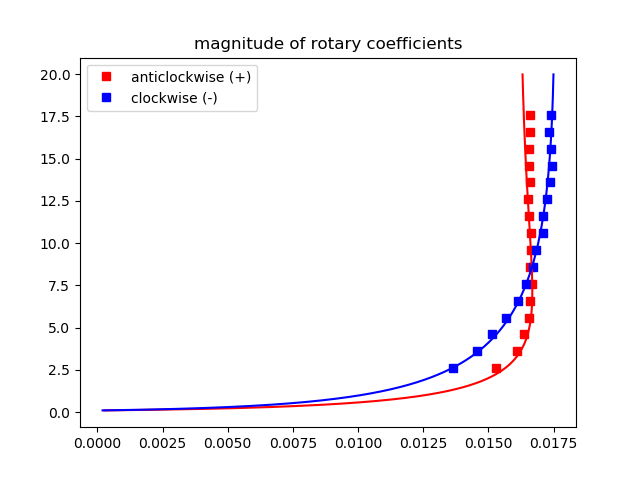

Text(0.5, 1.0, 'magnitude of rotary coefficients')

In [15]:
phip = np.angle(Rp)
phim = np.angle(Rm)

phi = (phim-phip)/2
PHI = (phim+phip)/2

Ua = np.abs(Rp) + np.abs(Rm)
Ub = np.abs(Rp) - np.abs(Rm)

plt.figure()
plt.plot(Ap[:,m2i][zi],dstide['height'][zi],'rs')
plt.plot(Am[:,m2i][zi],dstide['height'][zi],'bs')
plt.plot(np.abs(Rp),z,'r')
plt.plot(np.abs(Rm),z,'b')
plt.legend(['anticlockwise (+)','clockwise (-)'])
plt.title('magnitude of rotary coefficients')

In [ ]:
plt.figure()
plt.plot(dstide['Lsmaj'][zi,m2i],dstide['height'][zi],'rs')
plt.plot(dstide['Lsmin'][zi,m2i],dstide['height'][zi],'bs')
plt.plot(Ua,z,'r')
plt.plot(Ub,z,'b')
plt.legend(['major','minor'])
plt.title('major/minor axes')

<IPython.core.display.Javascript object>


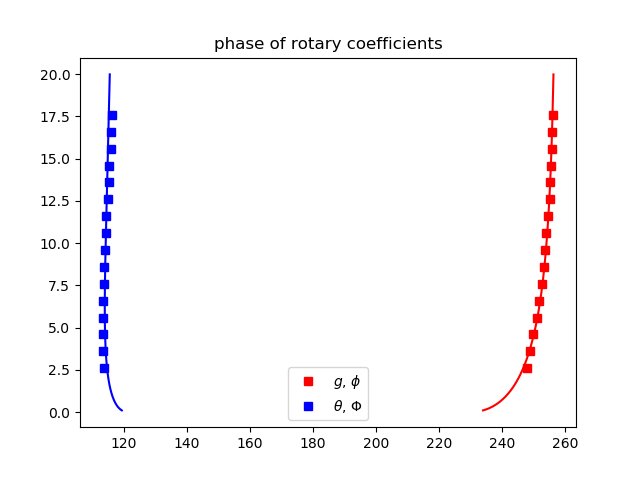

Text(0.5, 1.0, 'phase of rotary coefficients')

In [16]:
plt.figure()
plt.plot(dstide['g'][:,m2i][zi],dstide['height'][zi],'rs')
plt.plot(dstide['theta'][:,m2i][zi],dstide['height'][zi],'bs')
# add 180 degrees?
plt.plot(phi*180/np.pi+180,z,'r')
plt.plot(PHI*180/np.pi+180,z,'b')
plt.legend(['$g$, $\phi$','$\\theta$, $\Phi$'])
plt.title('phase of rotary coefficients')

In [ ]:
plt.figure()
plt.plot(np.real(ap[:,m2i][zi]),dstide['height'][zi],'rs')
plt.plot(np.imag(ap[:,m2i][zi]),dstide['height'][zi],'ro')
plt.plot(np.real(am[:,m2i][zi]),dstide['height'][zi],'bs')
plt.plot(np.imag(am[:,m2i][zi]),dstide['height'][zi],'bo')
plt.plot(np.real(Rp),z,'r-')
plt.plot(np.imag(Rp),z,'r--')
plt.plot(np.real(Rm),z,'b-')
plt.plot(np.imag(Rm),z,'b--')
plt.title('complex rotary coefficients')

<IPython.core.display.Javascript object>


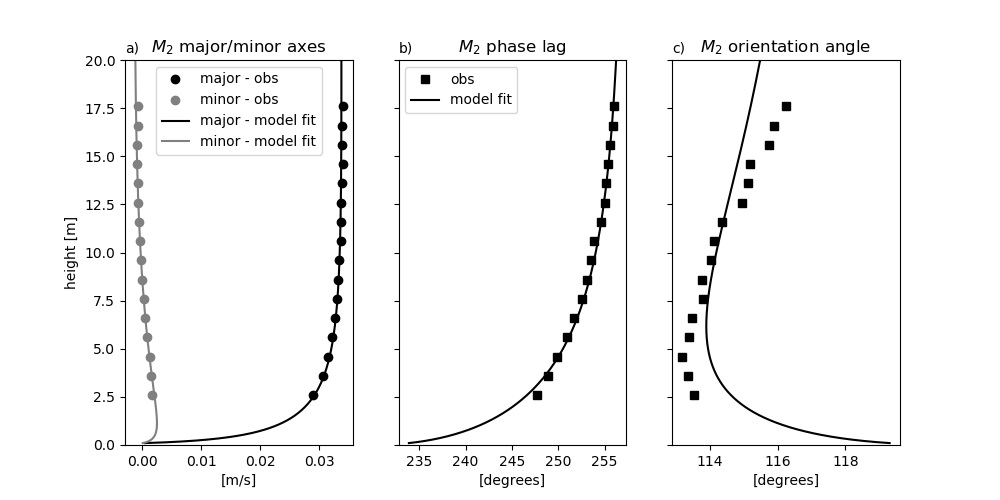

In [17]:
plt.figure(figsize=(10,5))
plt.subplot(131)
plt.plot(dstide['Lsmaj'][zi,m2i],dstide['height'][zi],'ko')
plt.plot(dstide['Lsmin'][zi,m2i],dstide['height'][zi],'o',color='gray')
plt.plot(Ua,z,'k')
plt.plot(Ub,z,color='gray')
plt.legend(['major - obs','minor - obs','major - model fit','minor - model fit'])
plt.title('$M_2$ major/minor axes')
plt.ylabel('height [m]')
plt.xlabel('[m/s]')
plt.ylim([0,20])
xl = plt.xlim()
yl = plt.ylim()
plt.text(xl[0],yl[1]+0.02*np.diff(yl),'a)')

plt.subplot(133)
plt.plot(PHI*180/np.pi+180,z,'k')
plt.plot(dstide['theta'][:,m2i][zi],dstide['height'][zi],'ks')
#plt.legend(['$g$, $\phi$','$\\theta$, $\Phi$'])
plt.title('phase of rotary coefficients')
plt.title('$M_2$ orientation angle')
plt.gca().set_yticklabels([])
plt.xlabel('[degrees]')
plt.ylim([0,20])
xl = plt.xlim()
yl = plt.ylim()
plt.text(xl[0],yl[1]+0.02*np.diff(yl),'c)')

plt.subplot(132)
plt.plot(dstide['g'][:,m2i][zi],dstide['height'][zi],'ks')
# add 180 degrees?
plt.plot(phi*180/np.pi+180,z,'k')
plt.title('$M_2$ phase lag')
plt.gca().set_yticklabels([])
plt.xlabel('[degrees]')
plt.legend(['obs','model fit'])
plt.ylim([0,20])
xl = plt.xlim()
yl = plt.ylim()
plt.text(xl[0],yl[1]+0.02*np.diff(yl),'b)')

plt.savefig('figures_paper/tidal_model_fit_M2.png',dpi=600)
plt.savefig('figures_paper/tidal_model_fit_M2.pdf')